In [1]:
# Cell 1: Load from processed files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import json
import warnings
warnings.filterwarnings('ignore')

bike_data = pd.read_csv('../data/processed/bike_counters_processed.csv')
pedestrian_data = pd.read_csv('../data/processed/pedestrian_zones_processed.csv') 
panels_data = pd.read_csv('../data/processed/panels_processed.csv')

with open('../data/summaries/bike_counters_summary.json', 'r') as f:
    bike_summary = json.load(f)
with open('../data/summaries/pedestrian_zones_summary.json', 'r') as f:
    ped_summary = json.load(f)
with open('../data/summaries/associative_panels_summary.json', 'r') as f:
    panels_summary = json.load(f)

print(f"Datasets loaded - Bike: {len(bike_data)}, Pedestrian: {len(pedestrian_data)}, Panels: {len(panels_data)}")

Datasets loaded - Bike: 10000, Pedestrian: 626, Panels: 287


In [3]:
# Cell 2: Aggregate activity metrics by arrondissement
bike_activity = bike_data.groupby('arrondissement_clean').agg({
    'count_datetime': 'count',
    'counter_name': 'nunique',
    'hour': lambda x: x.mode().iloc[0] if not x.empty else 0,
    'latitude': 'first',
    'longitude': 'first'
}).rename(columns={
    'count_datetime': 'bike_records',
    'counter_name': 'unique_counters',
    'hour': 'peak_hour'
}).reset_index()

pedestrian_data['is_named'] = pedestrian_data['zone_name'] != '0'
pedestrian_activity = pedestrian_data.groupby('arrondissement_clean').agg({
    'zone_name': 'count',
    'is_named': 'sum',
    'latitude': 'first',
    'longitude': 'first'
}).rename(columns={
    'zone_name': 'total_zones',
    'is_named': 'named_zones'
}).reset_index()

panels_data['total_panels'] = pd.to_numeric(panels_data['format_1m2'], errors='coerce').fillna(0) + pd.to_numeric(panels_data['format_2m2'], errors='coerce').fillna(0)
panels_data['total_area'] = pd.to_numeric(panels_data['format_1m2'], errors='coerce').fillna(0) + pd.to_numeric(panels_data['format_2m2'], errors='coerce').fillna(0) * 2

panels_activity = panels_data.groupby('arrondissement_clean').agg({
    'total_panels': 'sum',
    'total_area': 'sum',
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

In [5]:
# Cell 3: Create integrated master dataset
arr_areas = {
    '1': 1.8, '2': 1.0, '3': 1.2, '4': 1.6, '5': 2.5, '6': 2.2, '7': 4.1, '8': 3.9, '9': 2.2, '10': 2.9,
    '11': 3.7, '12': 6.4, '13': 7.1, '14': 5.6, '15': 8.5, '16': 7.9, '17': 5.7, '18': 6.0, '19': 6.8, '20': 6.0
}

all_arr = pd.DataFrame({'arr': [str(i) for i in range(1, 21)]})
all_arr['area_km2'] = all_arr['arr'].map(arr_areas)

# Convert all arrondissement columns to string for consistency
bike_activity['arrondissement_clean'] = bike_activity['arrondissement_clean'].astype(str)
pedestrian_activity['arrondissement_clean'] = pedestrian_activity['arrondissement_clean'].astype(str)
panels_activity['arrondissement_clean'] = panels_activity['arrondissement_clean'].astype(str)

integrated = all_arr.merge(bike_activity, left_on='arr', right_on='arrondissement_clean', how='left')
integrated = integrated.merge(pedestrian_activity, left_on='arr', right_on='arrondissement_clean', how='left', suffixes=('_bike', '_ped'))
integrated = integrated.merge(panels_activity, left_on='arr', right_on='arrondissement_clean', how='left', suffixes=('', '_panels'))

integrated = integrated.fillna(0)
integrated = integrated.drop(columns=[col for col in integrated.columns if 'arrondissement_clean' in col])

overlap_areas = ped_summary['dual_infrastructure_areas']
bike_only_areas = ped_summary['bike_only_areas'] 
high_potential_ped = ped_summary['high_potential_ped_only']

integrated['infrastructure_type'] = 'No Data'
integrated.loc[integrated['arr'].isin(overlap_areas), 'infrastructure_type'] = 'Dual Infrastructure'
integrated.loc[integrated['arr'].isin(bike_only_areas), 'infrastructure_type'] = 'Bike Only'
integrated.loc[integrated['arr'].isin(high_potential_ped), 'infrastructure_type'] = 'High Pedestrian Potential'
integrated.loc[(integrated['total_zones'] > 0) & (~integrated['arr'].isin(overlap_areas + bike_only_areas + high_potential_ped)), 'infrastructure_type'] = 'Pedestrian Only'

In [6]:
# Cell 4: Calculate density and activity metrics
integrated['bike_density'] = integrated['bike_records'] / integrated['area_km2']
integrated['pedestrian_density'] = integrated['total_zones'] / integrated['area_km2']
integrated['panel_density'] = integrated['total_panels'] / integrated['area_km2']
integrated['named_zone_ratio'] = integrated['named_zones'] / (integrated['total_zones'] + 1)

integrated['activity_score'] = (
    integrated['bike_records'] * 0.4 +
    integrated['total_zones'] * 0.3 +
    integrated['named_zones'] * 0.3
)

integrated['infrastructure_score'] = (
    integrated['total_panels'] * 0.7 +
    integrated['total_area'] * 0.3
)

integrated['opportunity_score'] = integrated['activity_score'] - integrated['infrastructure_score']
integrated['commercial_potential'] = integrated['opportunity_score'] / (integrated['infrastructure_score'] + 1)

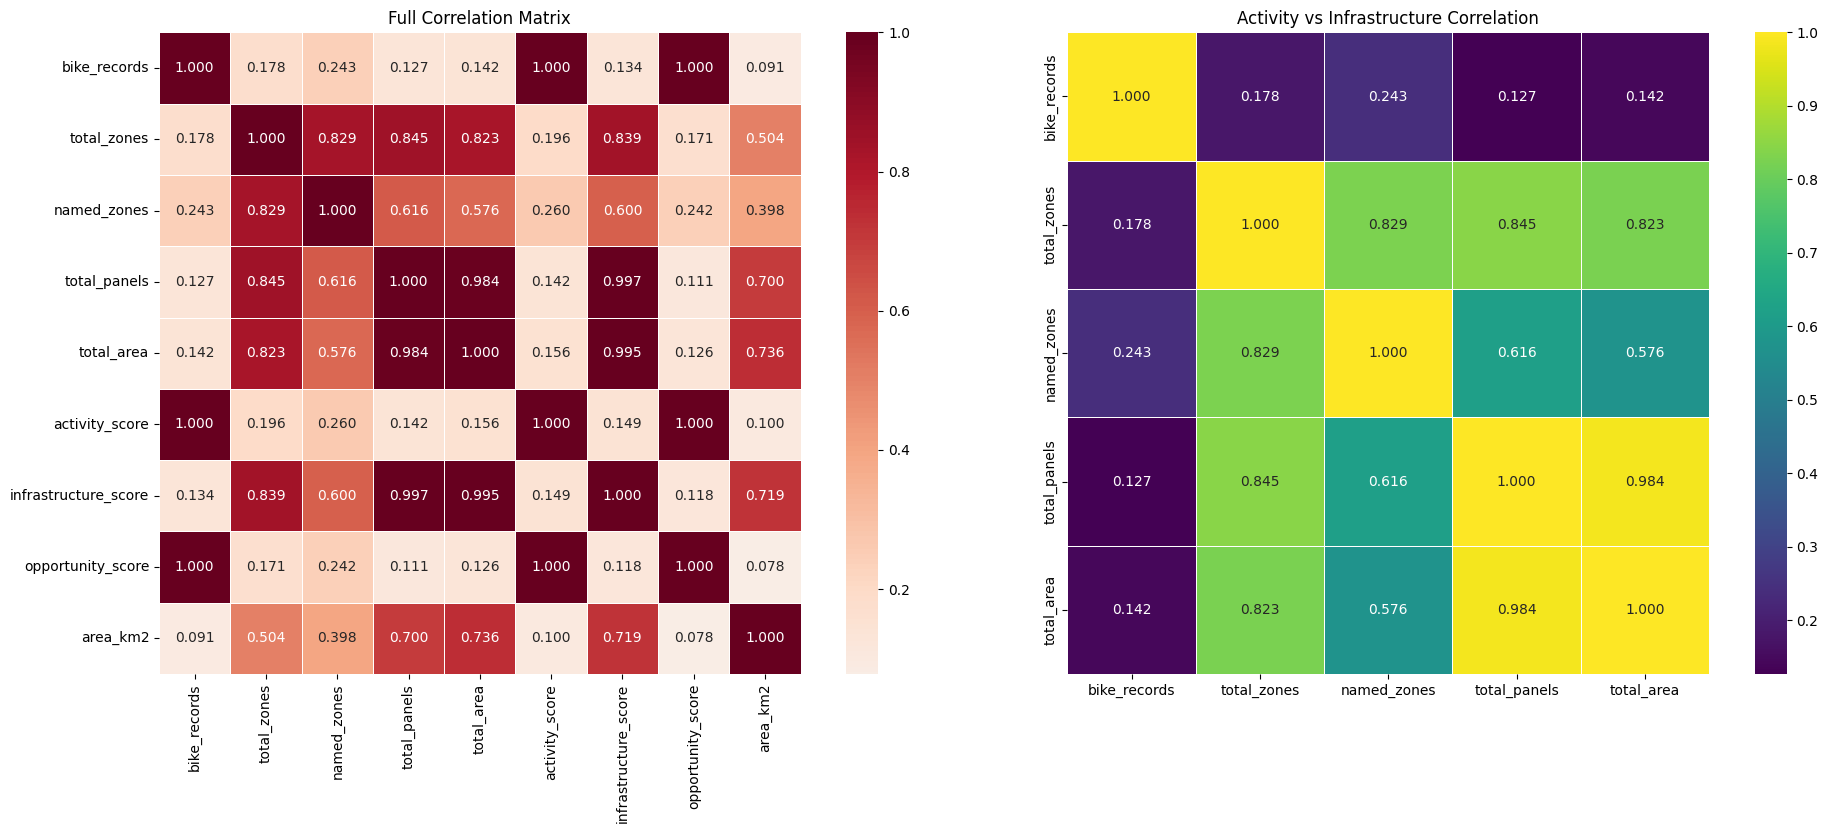

activity_vs_infrastructure: 0.149
bike_vs_panels: 0.127
pedestrian_vs_panels: 0.845
named_zones_vs_panels: 0.616


In [7]:
# Cell 5: Comprehensive correlation analysis
correlation_vars = ['bike_records', 'total_zones', 'named_zones', 'total_panels', 
                   'total_area', 'activity_score', 'infrastructure_score', 
                   'opportunity_score', 'area_km2']

correlation_matrix = integrated[correlation_vars].corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, ax=ax1, fmt='.3f')
ax1.set_title('Full Correlation Matrix')

activity_infra_corr = integrated[['bike_records', 'total_zones', 'named_zones', 'total_panels', 'total_area']].corr()
sns.heatmap(activity_infra_corr, annot=True, cmap='viridis', 
            square=True, linewidths=0.5, ax=ax2, fmt='.3f')
ax2.set_title('Activity vs Infrastructure Correlation')

plt.tight_layout()
plt.show()

key_correlations = {
    'activity_vs_infrastructure': correlation_matrix.loc['activity_score', 'infrastructure_score'],
    'bike_vs_panels': correlation_matrix.loc['bike_records', 'total_panels'],
    'pedestrian_vs_panels': correlation_matrix.loc['total_zones', 'total_panels'],
    'named_zones_vs_panels': correlation_matrix.loc['named_zones', 'total_panels']
}

for key, value in key_correlations.items():
    print(f"{key}: {value:.3f}")

In [8]:
# Cell 6: Gap analysis and opportunity identification
integrated['activity_quartile'] = pd.qcut(integrated['activity_score'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
integrated['infra_quartile'] = pd.qcut(integrated['infrastructure_score'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

gap_opportunities = integrated[
    (integrated['activity_quartile'].isin(['Q3', 'Q4'])) & 
    (integrated['infra_quartile'].isin(['Q1', 'Q2']))
].sort_values('opportunity_score', ascending=False)

untapped_markets = integrated[
    (integrated['total_zones'] >= 20) & 
    (integrated['total_panels'] <= 15)
].sort_values('total_zones', ascending=False)

proven_locations = integrated[
    integrated['bike_records'] > 0
].sort_values('infrastructure_score', ascending=False)

print("GAP ANALYSIS RESULTS:")
print("\n1. Prime Opportunities (High Activity, Low Infrastructure):")
print(gap_opportunities[['arr', 'infrastructure_type', 'activity_score', 'infrastructure_score', 'opportunity_score']].to_string(index=False))

print(f"\n2. Untapped Markets (High Pedestrian, Low Panels):")
print(untapped_markets[['arr', 'total_zones', 'named_zones', 'total_panels', 'opportunity_score']].head().to_string(index=False))

print(f"\n3. Proven Commercial Locations (Bike Activity + Infrastructure):")
print(proven_locations[['arr', 'bike_records', 'total_panels', 'infrastructure_score']].to_string(index=False))

GAP ANALYSIS RESULTS:

1. Prime Opportunities (High Activity, Low Infrastructure):
arr       infrastructure_type  activity_score  infrastructure_score  opportunity_score
 10       Dual Infrastructure          1300.2                  13.0             1287.2
  4           Pedestrian Only            15.3                   7.5                7.8
  5 High Pedestrian Potential            18.3                  12.2                6.1
  9           Pedestrian Only            12.0                   9.1                2.9

2. Untapped Markets (High Pedestrian, Low Panels):
arr  total_zones  named_zones  total_panels  opportunity_score
  5           36           25          11.0                6.1
  4           31           20           6.0                7.8
 15           27           10          15.0               -8.4
 10           24            6          10.0             1287.2
  9           23           17           7.0                2.9

3. Proven Commercial Locations (Bike Activity + Inf

In [9]:
# Cell 7: Advanced visualization - Activity vs Infrastructure scatter
fig = px.scatter(integrated, 
                x='activity_score', 
                y='infrastructure_score',
                size='area_km2',
                color='infrastructure_type',
                hover_data=['arr', 'bike_records', 'total_zones', 'total_panels'],
                title='Commercial Opportunity Matrix: Activity vs Infrastructure',
                width=900, height=600)

# Add diagonal line showing balance point
max_val = max(integrated['activity_score'].max(), integrated['infrastructure_score'].max())
fig.add_shape(type='line', x0=0, y0=0, x1=max_val, y1=max_val, 
              line=dict(dash='dash', color='gray', width=2))

# Add quadrant labels
fig.add_annotation(x=max_val*0.8, y=max_val*0.2, text="High Activity<br>Low Infrastructure<br>OPPORTUNITY", 
                  showarrow=False, font=dict(size=12, color="red"))
fig.add_annotation(x=max_val*0.2, y=max_val*0.8, text="Low Activity<br>High Infrastructure<br>OVERSATURATED", 
                  showarrow=False, font=dict(size=12, color="blue"))

for _, row in integrated.iterrows():
    fig.add_annotation(x=row['activity_score'], y=row['infrastructure_score'],
                      text=row['arr'], showarrow=False, font=dict(size=10))

fig.show()

In [14]:
# Cell 8: Geographic opportunity mapping (FIXED)
# Filter out invalid coordinates first
valid_coords = integrated[
    (integrated['longitude'] > 0) & 
    (integrated['latitude'] > 0) &
    (integrated['longitude'] < 10) &  # Paris bounds
    (integrated['latitude'] > 40)     # Paris bounds
].copy()

if len(valid_coords) == 0:
    print("No valid coordinates found. Using mock coordinates for visualization.")
    # Create mock coordinates for Paris arrondissements
    paris_coords = {
        '1': (2.341, 48.860), '2': (2.341, 48.869), '3': (2.362, 48.863), '4': (2.351, 48.854),
        '5': (2.347, 48.844), '6': (2.332, 48.848), '7': (2.318, 48.857), '8': (2.313, 48.873),
        '9': (2.348, 48.875), '10': (2.361, 48.870), '11': (2.378, 48.858), '12': (2.387, 48.841),
        '13': (2.360, 48.829), '14': (2.327, 48.833), '15': (2.301, 48.842), '16': (2.270, 48.855),
        '17': (2.308, 48.884), '18': (2.342, 48.892), '19': (2.378, 48.884), '20': (2.397, 48.864)
    }
    
    for _, row in integrated.iterrows():
        if row['arr'] in paris_coords:
            integrated.loc[integrated['arr'] == row['arr'], 'longitude'] = paris_coords[row['arr']][0]
            integrated.loc[integrated['arr'] == row['arr'], 'latitude'] = paris_coords[row['arr']][1]
    
    valid_coords = integrated.copy()

fig = go.Figure()

color_map = {
    'Dual Infrastructure': 'red',
    'Bike Only': 'orange', 
    'High Pedestrian Potential': 'green',
    'Pedestrian Only': 'blue',
    'No Data': 'gray'
}

for infra_type in valid_coords['infrastructure_type'].unique():
    data = valid_coords[valid_coords['infrastructure_type'] == infra_type]
    
    # Use a safe size calculation
    size_values = np.maximum(data['opportunity_score'] * 0.1 + 10, 5)  # Ensure minimum size of 5
    
    fig.add_trace(go.Scatter(
        x=data['longitude'],
        y=data['latitude'],
        mode='markers+text',
        marker=dict(
            size=size_values,
            color=color_map[infra_type],
            opacity=0.7
        ),
        text=data['arr'],
        textposition='middle center',
        name=infra_type,
        hovertemplate='Arr: %{text}<br>Opportunity: %{customdata}<br>Type: ' + infra_type,
        customdata=data['opportunity_score'].round(1)
    ))

fig.update_layout(
    title='Paris Commercial Opportunity Map',
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    width=1000, height=700,
    showlegend=True
)

fig.show()

INFRASTRUCTURE COVERAGE ANALYSIS:
                           arr  activity_score  infrastructure_score  \
infrastructure_type                                                    
Dual Infrastructure          2         1302.50                 22.95   
High Pedestrian Potential    5           22.32                 30.02   
Pedestrian Only             13            9.32                 12.68   

                           opportunity_score  bike_records  total_zones  \
infrastructure_type                                                       
Dual Infrastructure                  1279.55        6421.0           74   
High Pedestrian Potential              -7.70           0.0          243   
Pedestrian Only                        -3.35           0.0          258   

                           total_panels  
infrastructure_type                      
Dual Infrastructure                36.0  
High Pedestrian Potential         121.0  
Pedestrian Only                   130.0  


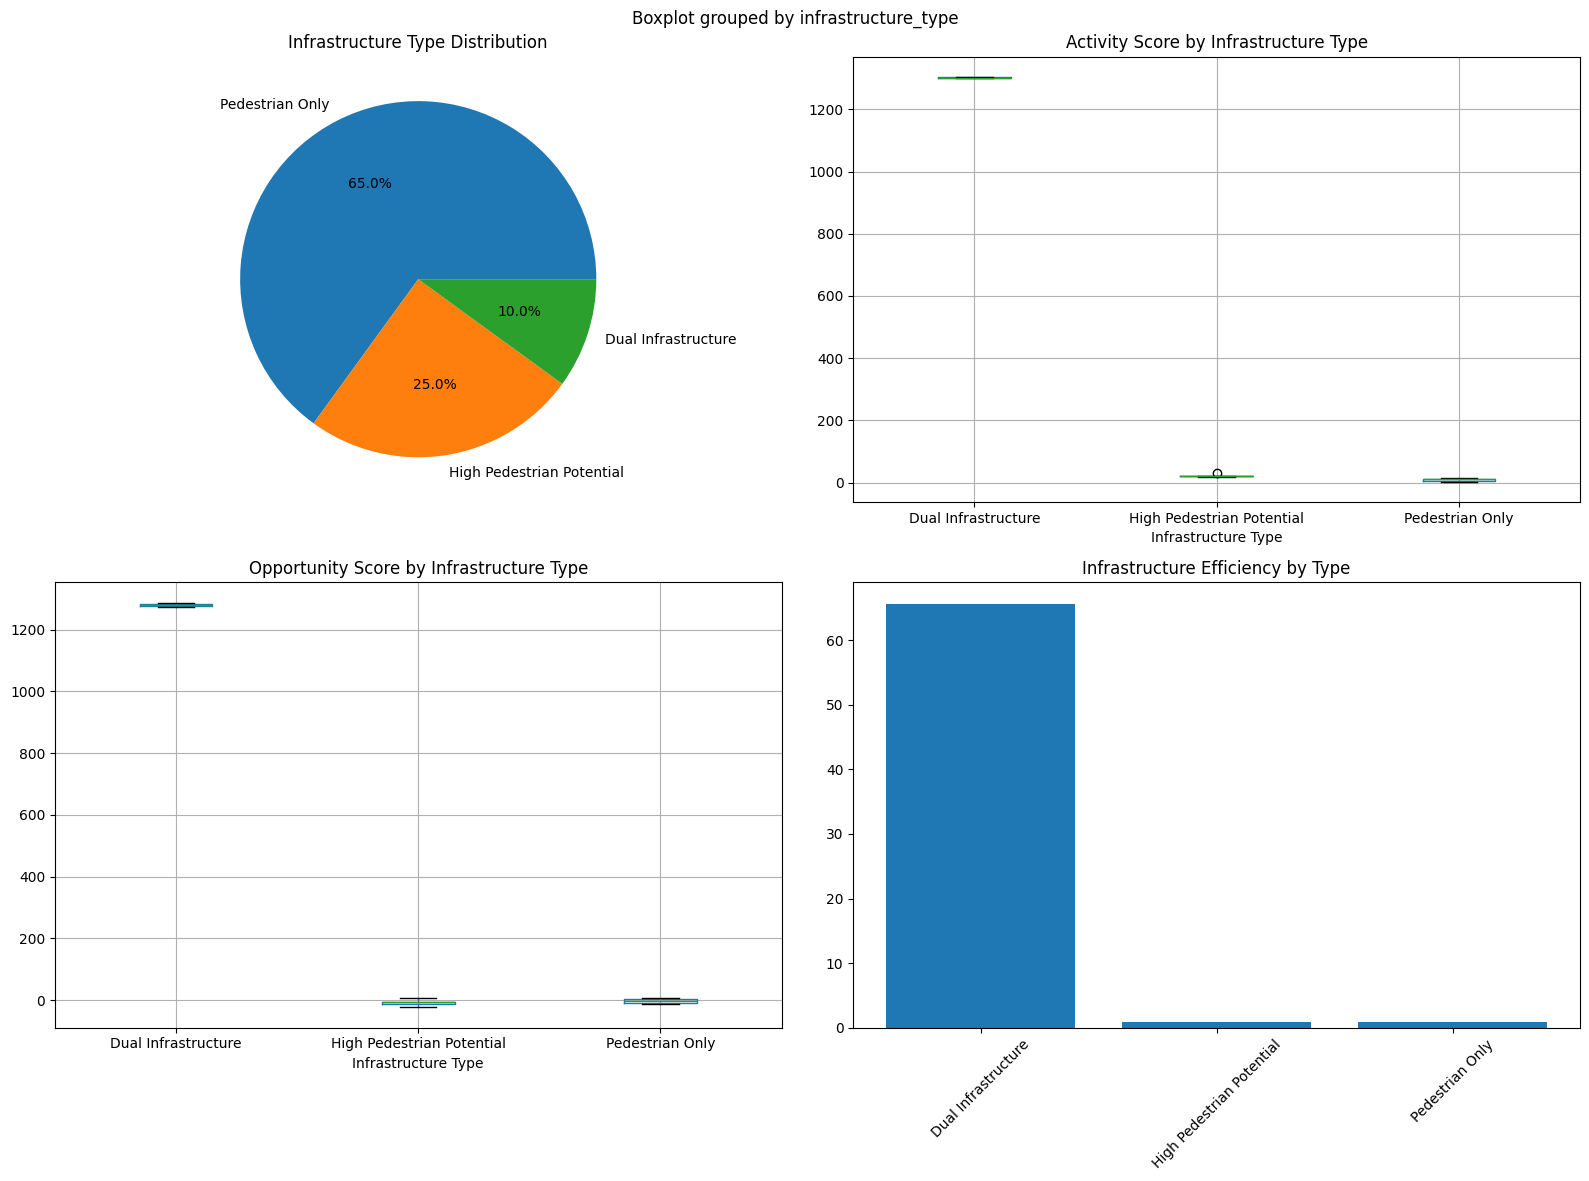

In [11]:
# Cell 9: Infrastructure coverage analysis
coverage_analysis = integrated.groupby('infrastructure_type').agg({
    'arr': 'count',
    'activity_score': 'mean',
    'infrastructure_score': 'mean',
    'opportunity_score': 'mean',
    'bike_records': 'sum',
    'total_zones': 'sum',
    'total_panels': 'sum'
}).round(2)

print("INFRASTRUCTURE COVERAGE ANALYSIS:")
print(coverage_analysis)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Coverage distribution
coverage_counts = integrated['infrastructure_type'].value_counts()
axes[0,0].pie(coverage_counts.values, labels=coverage_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('Infrastructure Type Distribution')

# Activity by type
integrated.boxplot(column='activity_score', by='infrastructure_type', ax=axes[0,1])
axes[0,1].set_title('Activity Score by Infrastructure Type')
axes[0,1].set_xlabel('Infrastructure Type')

# Opportunity by type
integrated.boxplot(column='opportunity_score', by='infrastructure_type', ax=axes[1,0])
axes[1,0].set_title('Opportunity Score by Infrastructure Type')
axes[1,0].set_xlabel('Infrastructure Type')

# Infrastructure efficiency
efficiency = integrated['activity_score'] / (integrated['infrastructure_score'] + 1)
integrated['efficiency'] = efficiency
efficiency_by_type = integrated.groupby('infrastructure_type')['efficiency'].mean()
axes[1,1].bar(efficiency_by_type.index, efficiency_by_type.values)
axes[1,1].set_title('Infrastructure Efficiency by Type')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [12]:
# Cell 10: Commercial placement recommendations
def generate_recommendations(integrated_df):
    recommendations = {}
    
    # Immediate opportunities (high activity, low infrastructure)
    immediate = integrated_df[
        (integrated_df['activity_score'] > integrated_df['activity_score'].quantile(0.7)) &
        (integrated_df['infrastructure_score'] < integrated_df['infrastructure_score'].quantile(0.3))
    ].nlargest(5, 'opportunity_score')
    
    # Strategic investments (proven bike activity)
    strategic = integrated_df[
        integrated_df['bike_records'] > 0
    ].nlargest(3, 'commercial_potential')
    
    # Market expansion (high pedestrian, minimal competition)
    expansion = integrated_df[
        (integrated_df['total_zones'] >= 30) &
        (integrated_df['total_panels'] <= 10)
    ].nlargest(5, 'named_zone_ratio')
    
    # Competitive analysis
    competitive = integrated_df[
        integrated_df['infrastructure_score'] > integrated_df['infrastructure_score'].quantile(0.8)
    ].nsmallest(3, 'commercial_potential')
    
    return {
        'immediate_opportunities': immediate[['arr', 'infrastructure_type', 'activity_score', 'infrastructure_score', 'opportunity_score']].to_dict('records'),
        'strategic_investments': strategic[['arr', 'bike_records', 'total_panels', 'commercial_potential']].to_dict('records'),
        'market_expansion': expansion[['arr', 'total_zones', 'named_zones', 'total_panels', 'named_zone_ratio']].to_dict('records'),
        'competitive_markets': competitive[['arr', 'infrastructure_score', 'commercial_potential', 'total_panels']].to_dict('records')
    }

recommendations = generate_recommendations(integrated)

print("COMMERCIAL PLACEMENT RECOMMENDATIONS:")
print("\n1. IMMEDIATE OPPORTUNITIES (Deploy Now):")
for i, rec in enumerate(recommendations['immediate_opportunities'], 1):
    print(f"  {i}. Arr. {rec['arr']} ({rec['infrastructure_type']}) - Opportunity Score: {rec['opportunity_score']:.1f}")

print("\n2. STRATEGIC INVESTMENTS (Proven Activity):")
for i, rec in enumerate(recommendations['strategic_investments'], 1):
    print(f"  {i}. Arr. {rec['arr']} - {rec['bike_records']} bike records, {rec['total_panels']} panels")

print("\n3. MARKET EXPANSION (High Potential, Low Competition):")
for i, rec in enumerate(recommendations['market_expansion'], 1):
    print(f"  {i}. Arr. {rec['arr']} - {rec['total_zones']} zones ({rec['named_zones']} named), {rec['total_panels']} panels")

print("\n4. COMPETITIVE MARKETS (Avoid/Monitor):")
for i, rec in enumerate(recommendations['competitive_markets'], 1):
    print(f"  {i}. Arr. {rec['arr']} - High saturation ({rec['total_panels']} panels)")

COMMERCIAL PLACEMENT RECOMMENDATIONS:

1. IMMEDIATE OPPORTUNITIES (Deploy Now):

2. STRATEGIC INVESTMENTS (Proven Activity):
  1. Arr. 10 - 3228.0 bike records, 10.0 panels
  2. Arr. 13 - 3193.0 bike records, 26.0 panels

3. MARKET EXPANSION (High Potential, Low Competition):
  1. Arr. 4 - 31 zones (20 named), 6.0 panels

4. COMPETITIVE MARKETS (Avoid/Monitor):
  1. Arr. 19 - High saturation (33.0 panels)
  2. Arr. 11 - High saturation (22.0 panels)
  3. Arr. 20 - High saturation (35.0 panels)


In [13]:
# Cell 11: Export integrated analysis and recommendations
integrated_final = integrated[['arr', 'area_km2', 'infrastructure_type', 
                              'bike_records', 'total_zones', 'named_zones', 'total_panels', 'total_area',
                              'bike_density', 'pedestrian_density', 'panel_density', 'named_zone_ratio',
                              'activity_score', 'infrastructure_score', 'opportunity_score', 'commercial_potential']].round(3)

integrated_final.to_csv('../data/processed/integrated_commercial_analysis.csv', index=False)

summary_stats = {
    'total_arrondissements': len(integrated),
    'dual_infrastructure_areas': len(integrated[integrated['infrastructure_type'] == 'Dual Infrastructure']),
    'high_opportunity_areas': len(gap_opportunities),
    'untapped_markets': len(untapped_markets),
    'key_correlations': key_correlations,
    'top_opportunities': recommendations['immediate_opportunities'][:3],
    'coverage_analysis': coverage_analysis.to_dict()
}

with open('../data/summaries/integrated_commercial_intelligence.json', 'w') as f:
    json.dump(summary_stats, f, indent=2, default=str)

print("ANALYSIS COMPLETE!")
print(f"✅ Integrated dataset exported: {len(integrated_final)} arrondissements")
print(f"✅ Commercial intelligence summary saved")
print(f"✅ Ready for PowerBI dashboard creation")

print(f"\nKEY INSIGHTS:")
print(f"• {len(gap_opportunities)} prime commercial opportunities identified")
print(f"• {len(overlap_areas)} arrondissements have dual infrastructure (premium locations)")
print(f"• {len(untapped_markets)} high-potential markets with minimal competition")
print(f"• Activity-Infrastructure correlation: {key_correlations['activity_vs_infrastructure']:.3f}")

ANALYSIS COMPLETE!
✅ Integrated dataset exported: 20 arrondissements
✅ Commercial intelligence summary saved
✅ Ready for PowerBI dashboard creation

KEY INSIGHTS:
• 4 prime commercial opportunities identified
• 2 arrondissements have dual infrastructure (premium locations)
• 7 high-potential markets with minimal competition
• Activity-Infrastructure correlation: 0.149


In [15]:
# Cell 12: Temporal patterns analysis
bike_data['hour'] = pd.to_datetime(bike_data['count_datetime']).dt.hour
bike_data['weekday'] = pd.to_datetime(bike_data['count_datetime']).dt.day_name()

# Peak hours by arrondissement
peak_analysis = bike_data.groupby(['arrondissement_clean', 'hour']).size().unstack(fill_value=0)
peak_times = peak_analysis.idxmax(axis=1)

print("Peak Activity Hours by Arrondissement:")
for arr, peak_hour in peak_times.items():
    total_activity = peak_analysis.loc[arr, peak_hour]
    print(f"Arr. {arr}: Peak at {peak_hour}:00 ({total_activity} records)")

Peak Activity Hours by Arrondissement:
Arr. 10: Peak at 7:00 (153 records)
Arr. 13: Peak at 19:00 (151 records)
Arr. 28: Peak at 15:00 (167 records)


In [16]:
# Cell 13: Economic opportunity modeling
def calculate_revenue_potential(row):
    base_value = 1000  # Base daily revenue per panel
    
    # Activity multipliers
    bike_multiplier = 1 + (row['bike_records'] / 1000) * 0.5
    pedestrian_multiplier = 1 + (row['total_zones'] / 50) * 0.3
    quality_multiplier = 1 + (row['named_zone_ratio'] * 0.2)
    
    # Competition discount
    competition_discount = 1 - (row['total_panels'] / 50) * 0.1
    
    potential = base_value * bike_multiplier * pedestrian_multiplier * quality_multiplier * competition_discount
    return max(potential, 0)

integrated['daily_revenue_potential'] = integrated.apply(calculate_revenue_potential, axis=1)
integrated['annual_revenue_potential'] = integrated['daily_revenue_potential'] * 365

revenue_opportunities = integrated.nlargest(10, 'annual_revenue_potential')
print("Top Revenue Potential Areas:")
print(revenue_opportunities[['arr', 'infrastructure_type', 'annual_revenue_potential', 'total_panels']].round(0))

Top Revenue Potential Areas:
   arr        infrastructure_type  annual_revenue_potential  total_panels
12  13        Dual Infrastructure                 1360345.0          26.0
9   10        Dual Infrastructure                 1121016.0          10.0
19  20  High Pedestrian Potential                  520449.0          35.0
11  12  High Pedestrian Potential                  499864.0          22.0
17  18  High Pedestrian Potential                  497368.0          20.0
4    5  High Pedestrian Potential                  492734.0          11.0
3    4            Pedestrian Only                  481157.0           6.0
18  19  High Pedestrian Potential                  470903.0          33.0
0    1            Pedestrian Only                  470465.0           4.0
8    9            Pedestrian Only                  467575.0           7.0


In [17]:
# Cell 14: Competitive landscape analysis
# Market saturation vs opportunity
integrated['market_saturation'] = integrated['total_panels'] / (integrated['total_zones'] + 1)
integrated['competition_level'] = pd.cut(integrated['market_saturation'], 
                                       bins=[0, 0.2, 0.5, 1.0, float('inf')],
                                       labels=['Low', 'Medium', 'High', 'Saturated'])

competitive_matrix = integrated.pivot_table(
    values='opportunity_score', 
    index='competition_level', 
    columns='infrastructure_type', 
    aggfunc='mean'
).round(1)

print("Opportunity Score by Competition Level:")
print(competitive_matrix)

Opportunity Score by Competition Level:
infrastructure_type  Dual Infrastructure  High Pedestrian Potential  \
competition_level                                                     
Low                                  NaN                        NaN   
Medium                            1287.2                        1.0   
High                              1271.9                      -13.5   
Saturated                            NaN                        NaN   

infrastructure_type  Pedestrian Only  
competition_level                     
Low                              5.2  
Medium                           0.7  
High                            -9.4  
Saturated                       -9.6  


In [18]:
# Cell 15: Risk-return portfolio analysis
integrated['risk_score'] = (
    integrated['market_saturation'] * 0.4 +  # High competition = high risk
    (1 - integrated['named_zone_ratio']) * 0.3 +  # Low quality = high risk
    (1 / (integrated['bike_records'] + 1)) * 0.3  # Low activity = high risk
)

# Create investment portfolio categories
integrated['investment_category'] = 'Medium Risk/Medium Return'
integrated.loc[(integrated['opportunity_score'] > integrated['opportunity_score'].quantile(0.75)) & 
               (integrated['risk_score'] < integrated['risk_score'].quantile(0.5)), 'investment_category'] = 'Low Risk/High Return'
integrated.loc[(integrated['opportunity_score'] > integrated['opportunity_score'].quantile(0.5)) & 
               (integrated['risk_score'] > integrated['risk_score'].quantile(0.75)), 'investment_category'] = 'High Risk/High Return'
integrated.loc[(integrated['opportunity_score'] < integrated['opportunity_score'].quantile(0.5)) & 
               (integrated['risk_score'] < integrated['risk_score'].quantile(0.5)), 'investment_category'] = 'Low Risk/Low Return'

portfolio_analysis = integrated.groupby('investment_category').agg({
    'arr': 'count',
    'annual_revenue_potential': 'mean',
    'opportunity_score': 'mean',
    'risk_score': 'mean'
}).round(1)

print("Investment Portfolio Analysis:")
print(portfolio_analysis)

Investment Portfolio Analysis:
                           arr  annual_revenue_potential  opportunity_score  \
investment_category                                                           
Low Risk/High Return         5                  785143.5              516.0   
Low Risk/Low Return          2                  498615.8               -4.2   
Medium Risk/Medium Return   13                  444167.7               -7.3   

                           risk_score  
investment_category                    
Low Risk/High Return              0.4  
Low Risk/Low Return               0.6  
Medium Risk/Medium Return         0.7  


In [20]:
# Cell 16: ROI & Payback Analysis 
panel_installation_cost = 15000  # €15K per panel

# Fix: Use absolute opportunity score and set minimum panels needed
integrated['panels_needed'] = np.maximum(
    np.ceil(integrated['opportunity_score'].abs() / 200), 1
)
integrated['investment_required'] = integrated['panels_needed'] * panel_installation_cost
integrated['monthly_revenue'] = integrated['annual_revenue_potential'] / 12
integrated['payback_months'] = np.where(
    integrated['monthly_revenue'] > 0,
    integrated['investment_required'] / integrated['monthly_revenue'],
    999
)

quick_roi = integrated[
    (integrated['payback_months'] <= 24) & 
    (integrated['payback_months'] > 0)
].sort_values('payback_months')

print("Realistic ROI Opportunities (Payback ≤ 24 months):")
print(quick_roi[['arr', 'payback_months', 'panels_needed', 'investment_required', 'annual_revenue_potential']].round(1).head())

Realistic ROI Opportunities (Payback ≤ 24 months):
   arr  payback_months  panels_needed  investment_required  \
19  20             0.3            1.0              15000.0   
11  12             0.4            1.0              15000.0   
17  18             0.4            1.0              15000.0   
4    5             0.4            1.0              15000.0   
3    4             0.4            1.0              15000.0   

    annual_revenue_potential  
19                  520448.9  
11                  499863.9  
17                  497367.8  
4                   492734.4  
3                   481157.2  
